# **Overview:**

Chương trình này là tiếp nối của chương trình Part-2_Visualization.ipynb

Chương trình là thử nghiệm các mô hình Machine Learning trên tập dữ liệu đã được xử lý cũng như có cái nhìn tổng quan từ 2 phần trước.

# **6. Khai báo và cài đặt cần sử dụng**

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.model_selection import KFold
from datetime import datetime
import warnings

In [25]:
from pylab import rcParams

rcParams['figure.figsize'] = 16,9

### **Đọc dữ liệu**

In [26]:
# from google.colab import drive
# drive.mount('data')

In [27]:
df = pd.read_csv('data/newProcessed.csv')

In [28]:
df

,Index,Domain,Subdomain_Level,Url_Length,Url_Depth,Have_At_Sign,Have_Tilde_Symbol,No_Https,Having_IP,Domain_In_Subdomains,...,DNS,Domain_Age,Domain_End,Rank_Host,Rank_Country,Iframe,Mouse_Over,Right_Click,Forwarding,Label
0,0,google.com,1,43,1,0,0,0,0,1,...,0,0,0,1,1,0,1,0,0,0
1,1,google.com,1,36,1,0,0,0,0,1,...,0,0,0,1,1,0,1,0,0,0
2,2,google.com,1,41,1,0,0,0,0,1,...,0,0,0,1,1,0,1,0,0,0
3,3,bilnet.eu,1,16,0,0,0,1,0,0,...,0,1,1,1,1,0,0,0,1,0
4,4,bil-privatebanking.eu,1,28,0,0,0,1,0,0,...,0,1,1,1,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14137,14137,sites.google.com,1,45,2,0,0,0,0,1,...,0,0,0,1,1,0,0,0,0,1
14138,14138,sites.google.com,1,45,2,0,0,1,0,1,...,0,0,0,1,1,0,0,0,0,1
14139,14139,habbocreditosparati.blogspot.com,1,44,0,0,0,1,0,1,...,1,1,1,1,1,0,0,0,0,1
14140,14140,creditiperhabbogratissicuro100.blogspot.com,1,95,3,0,0,1,0,1,...,1,1,1,1,1,0,0,0,0,1


**Kiểm tra độ quan trọng của đăc trưng (feature important)**

In [29]:
df.columns

Index(['Index', 'Domain', 'Subdomain_Level', 'Url_Length', 'Url_Depth',
       'Have_At_Sign', 'Have_Tilde_Symbol', 'No_Https', 'Having_IP',
       'Domain_In_Subdomains', 'Domain_In_Paths', 'Http_In_Hostname',
       'Double_Slash_In_Path', 'Num_Dots', 'Num_Dashes_In_Hostname',
       'Num_Underscore', 'Num_Percent', 'Num_Query_Components',
       'Num_Ampersand', 'Num_Hash', 'Num_Numeric_Chars', 'Path_Length',
       'Query_Length', 'Num_Sensitive_Words', 'Ext_Favicon', 'Redirection',
       'Tiny_URL', 'Prefix_Suffix', 'DNS', 'Domain_Age', 'Domain_End',
       'Rank_Host', 'Rank_Country', 'Iframe', 'Mouse_Over', 'Right_Click',
       'Forwarding', 'Label'],
      dtype='object')

In [61]:
features = ['Subdomain_Level', 'Url_Length', 'Have_At_Sign', 'Have_Tilde_Symbol', 'No_Https', 'Having_IP', 'Domain_In_Subdomains', 'Domain_In_Paths', 'Http_In_Hostname', 'Double_Slash_In_Path', 'Num_Dots', 'Num_Dashes_In_Hostname', 'Num_Underscore', 'Num_Percent', 'Num_Query_Components', 'Num_Ampersand', 'Num_Hash', 'Num_Numeric_Chars', 'Path_Length', 'Query_Length', 'Num_Sensitive_Words', 'Ext_Favicon', 'Redirection', 'Tiny_URL', 'Prefix_Suffix', 'DNS', 'Domain_Age', 'Domain_End', 'Rank_Host', 'Rank_Country', 'Iframe', 'Mouse_Over', 'Right_Click', 'Forwarding']

In [62]:
X = df[features]
y = df['Label']

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [64]:
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostClassifier
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

RandomForestRegressor()

In [65]:
rf.feature_importances_

array([0.        , 0.23159935, 0.01602953, 0.0008686 , 0.03426387,
       0.00033472, 0.02511407, 0.0010758 , 0.        , 0.00077191,
       0.05873328, 0.04016588, 0.02060891, 0.00615559, 0.0065218 ,
       0.00540217, 0.00532026, 0.09837989, 0.15867039, 0.0842413 ,
       0.01520381, 0.        , 0.00234277, 0.0195195 , 0.02873098,
       0.00963608, 0.02375412, 0.03580836, 0.03292208, 0.0010221 ,
       0.00723955, 0.0082895 , 0.00845045, 0.01282336])

<BarContainer object of 34 artists>

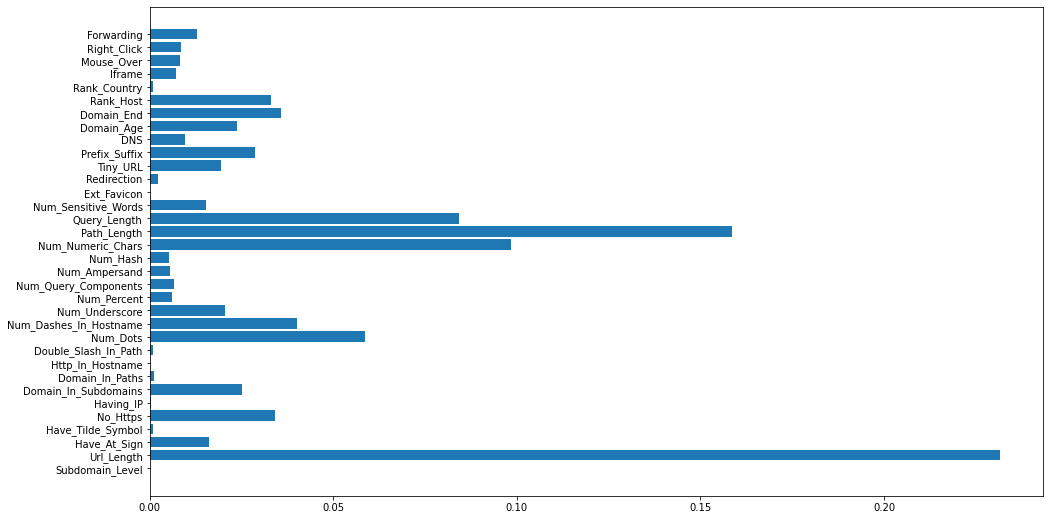

In [66]:
plt.barh(features, rf.feature_importances_)

# **7. Huấn luyện mô hình - Classification**

**Split dataset**

In [67]:
Y = y

In [68]:
from sklearn.model_selection import train_test_split

In [69]:
X_train,X_test,Y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=42)

In [70]:
print('Kích thước tập huấn luyện: ', X_train.shape, y_train.shape)
print('Kích thước tập kiểm tra: ', X_test.shape, y_test.shape)

Kích thước tập huấn luyện:  (11313, 34) (9899,)
Kích thước tập kiểm tra:  (2829, 34) (2829,)


In [71]:
# Hàm tính độ chính xác, ma trận nhầm lẫn, Recall, precision, f1 score và vẽ đồ thị ROC
from sklearn import metrics
from sklearn.model_selection import cross_val_score
def evaluate_model(model, X_test, y_test, y_prediction):
  print("Các chỉ số đánh giá mức độ hiệu quả của mô hình: ")
  #Accuracy
  print("1. Accuracy:",metrics.accuracy_score(y_prediction,y_test))
  # confusion_matrix
  print('2. confusion_matrix:')
  print(confusion_matrix(y_prediction,y_test))
  # recall_score
  print('3. recall_score: ', recall_score(y_prediction,y_test))
  # precision_score
  print('4. precision_score: ', precision_score(y_prediction,y_test))
  # f1_score
  print('5. f1_score: ', f1_score(y_prediction,y_test))
  # ROC plot
  print('6. Biểu đồ ROC của mô hình:')
  metrics.plot_roc_curve(model, X_test, y_test)
  plt.show()

**Logistic Regression**

/home/hikaru/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/hikaru/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


Các chỉ số đánh giá mức độ hiệu quả của mô hình: 
1. Accuracy: 0.6967126193001061
2. confusion_matrix:
[[ 779  379]
 [ 479 1192]]
3. recall_score:  0.713345302214243
4. precision_score:  0.7587523870146403
5. f1_score:  0.7353485502776064
6. Biểu đồ ROC của mô hình:


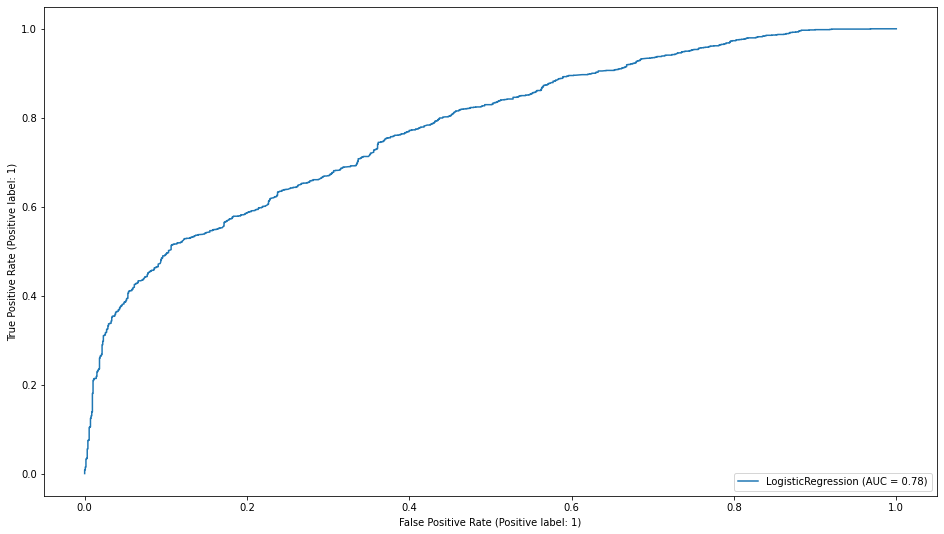

In [72]:
#Given smote, we have to do a little adjustment
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

logreg = LogisticRegression(fit_intercept=True, penalty='l2')
logreg.fit(X_train, Y_train)

logregprediction=logreg.predict(X_test)

evaluate_model (logreg, X_test, y_test, logregprediction)

**Linear Discriminant Analysis**

In [42]:
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# lda = LinearDiscriminantAnalysis()
# lda.fit(X_train, Y_train)

# lda_prediction=lda.predict(X_test)

# evaluate_model (lda, X_test, y_test, lda_prediction)

**Gaussian Naive Bayes**

Các chỉ số đánh giá mức độ hiệu quả của mô hình: 
1. Accuracy: 0.6705549664192294
2. confusion_matrix:
[[1096  770]
 [ 162  801]]
3. recall_score:  0.8317757009345794
4. precision_score:  0.50986632718014
5. f1_score:  0.6322020520915548
6. Biểu đồ ROC của mô hình:


/home/hikaru/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


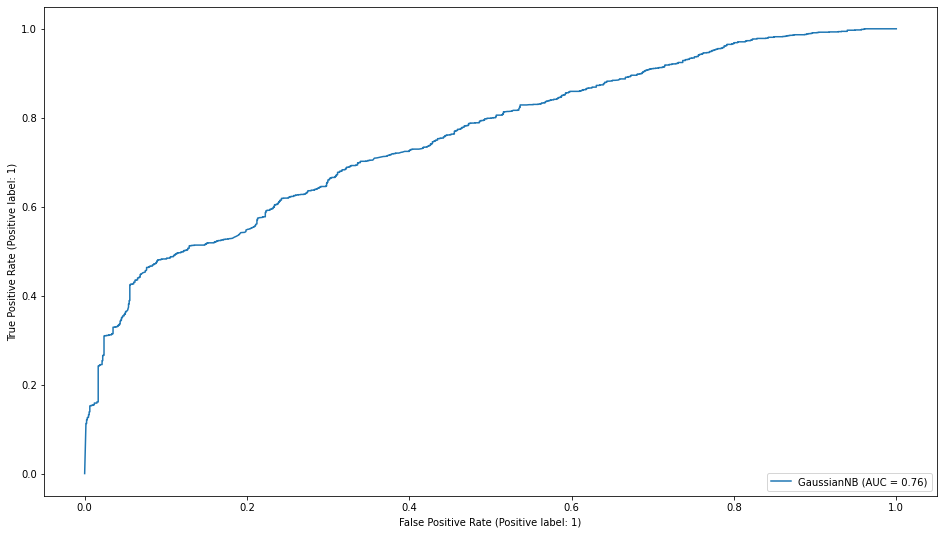

In [43]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, Y_train)

gnbprediction=gnb.predict(X_test)

evaluate_model (gnb, X_test, y_test, gnbprediction)

**Decision Tree Classifier**

Các chỉ số đánh giá mức độ hiệu quả của mô hình: 
1. Accuracy: 0.8041710851891127
2. confusion_matrix:
[[1031  327]
 [ 227 1244]]
3. recall_score:  0.8456832087015635
4. precision_score:  0.7918523233609166
5. f1_score:  0.8178829717291256
6. Biểu đồ ROC của mô hình:


/home/hikaru/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


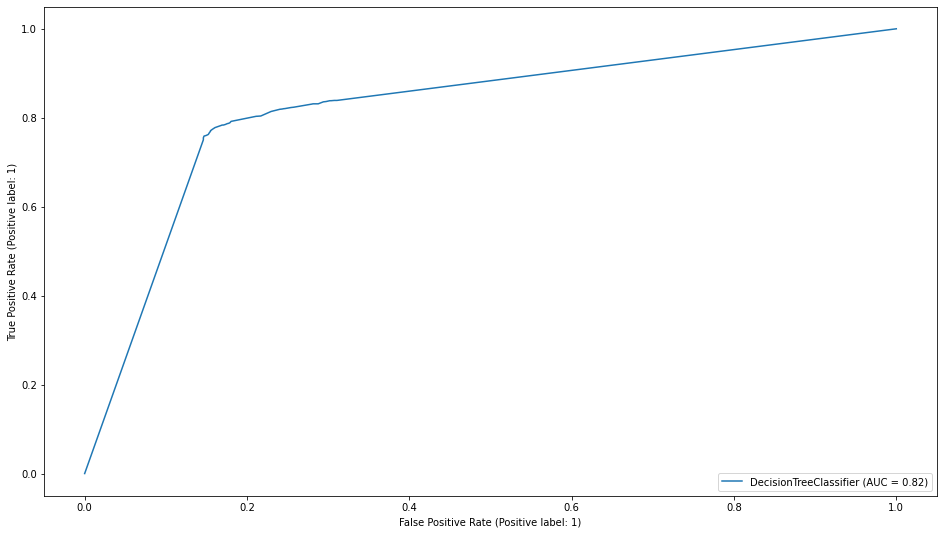

In [44]:
from sklearn.tree import DecisionTreeClassifier

dtc= DecisionTreeClassifier(random_state=42)
dtc.fit(X_train,Y_train)

dtcprediction=dtc.predict(X_test)

evaluate_model (dtc, X_test, y_test, dtcprediction)

**Random Forest Classifier**

Các chỉ số đánh giá mức độ hiệu quả của mô hình: 
1. Accuracy: 0.8144220572640509
2. confusion_matrix:
[[1024  291]
 [ 234 1280]]
3. recall_score:  0.845442536327609
4. precision_score:  0.8147676639083387
5. f1_score:  0.8298217179902756
6. Biểu đồ ROC của mô hình:


/home/hikaru/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


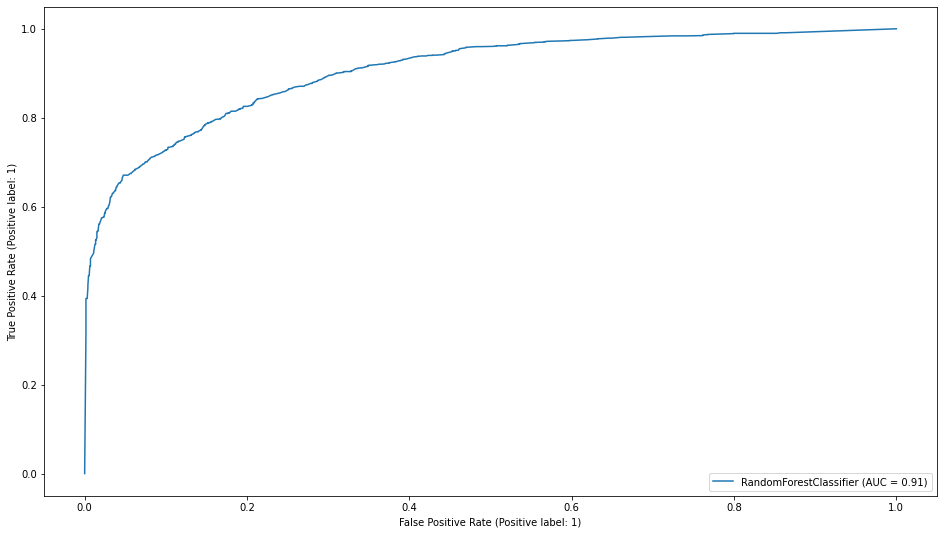

In [73]:
from sklearn.ensemble import RandomForestClassifier

rfc=RandomForestClassifier(n_jobs=-1,random_state=123)
#learning
rfc.fit(X_train,Y_train)
#Prediction
rfcprediction=rfc.predict(X_test)

evaluate_model (rfc, X_test, y_test, rfcprediction)


**SVM Classifier**

Các chỉ số đánh giá mức độ hiệu quả của mô hình: 
1. Accuracy: 0.6617179215270413
2. confusion_matrix:
[[ 483  182]
 [ 775 1389]]
3. recall_score:  0.6418669131238447
4. precision_score:  0.8841502227880331
5. f1_score:  0.7437751004016065
6. Biểu đồ ROC của mô hình:


/home/hikaru/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


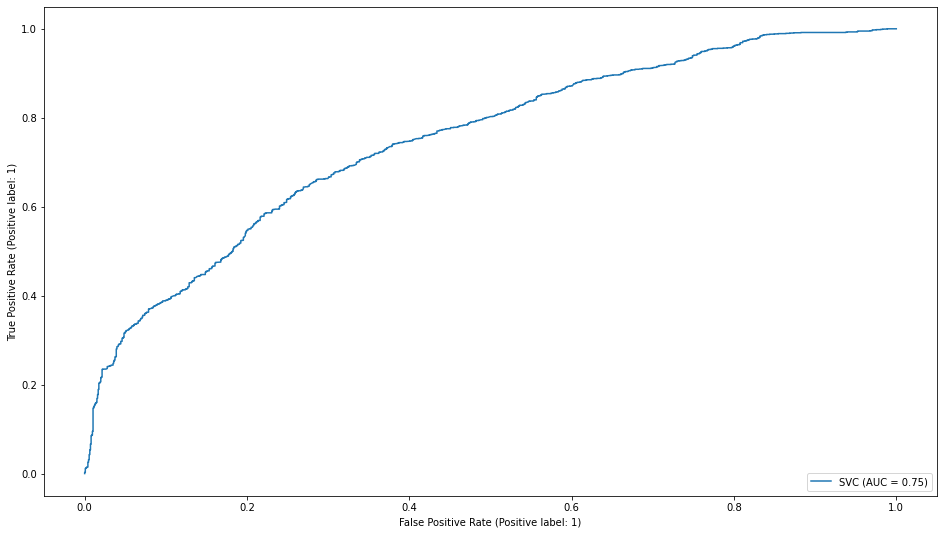

In [46]:
from sklearn import svm
#making the instance
svc = svm.SVC(random_state=123)
#learning
svc.fit(X_train,Y_train)
#Prediction
svcprediction=svc.predict(X_test)

evaluate_model (svc, X_test, y_test, svcprediction)

**K-NearestNeighbours Classifier**

Các chỉ số đánh giá mức độ hiệu quả của mô hình: 
1. Accuracy: 0.783315659243549
2. confusion_matrix:
[[ 941  296]
 [ 317 1275]]
3. recall_score:  0.8008793969849246
4. precision_score:  0.8115849777211966
5. f1_score:  0.8061966487511856
6. Biểu đồ ROC của mô hình:


/home/hikaru/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


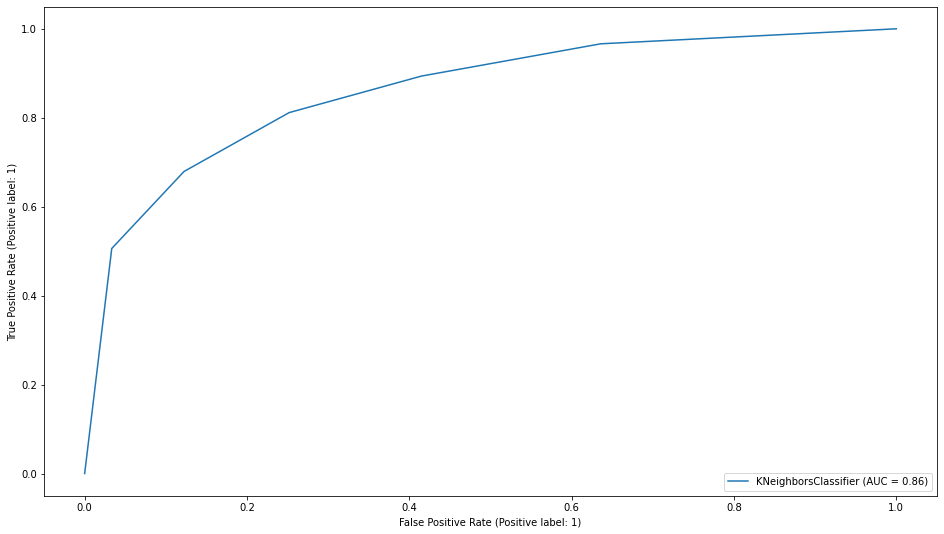

In [47]:
from sklearn.neighbors import KNeighborsClassifier
#making the instance
knn = KNeighborsClassifier()
#learning
knn.fit(X_train,Y_train)
#Prediction
knnprediction=knn.predict(X_test)

evaluate_model (knn, X_test, y_test, knnprediction)

**Ada Boost**

Các chỉ số đánh giá mức độ hiệu quả của mô hình: 
1. Accuracy: 0.7476139978791092
2. confusion_matrix:
[[ 939  395]
 [ 319 1176]]
3. recall_score:  0.7866220735785954
4. precision_score:  0.7485677912157861
5. f1_score:  0.767123287671233
6. Biểu đồ ROC của mô hình:


/home/hikaru/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


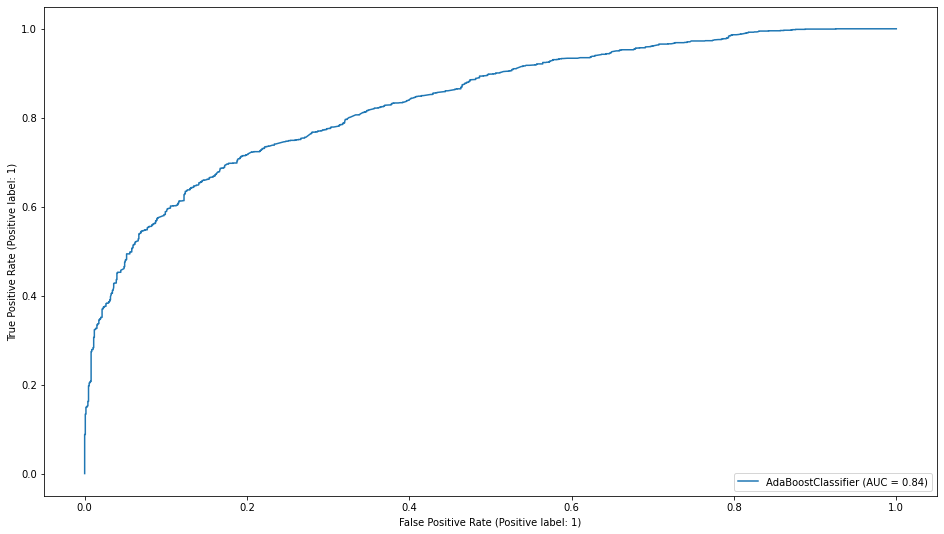

In [48]:
from sklearn.ensemble import AdaBoostClassifier

ada_model = AdaBoostClassifier(n_estimators=200, random_state=44)

#learning
ada_model.fit(X_train,Y_train)
#Prediction
ada_modelprediction=ada_model.predict(X_test)

evaluate_model (ada_model, X_test, y_test, ada_modelprediction)

**XGB Classifier**

Các chỉ số đánh giá mức độ hiệu quả của mô hình: 
1. Accuracy: 0.8119476846942383
2. confusion_matrix:
[[1008  282]
 [ 250 1289]]
3. recall_score:  0.8375568551007148
4. precision_score:  0.8204964990451942
5. f1_score:  0.8289389067524117
6. Biểu đồ ROC của mô hình:


/home/hikaru/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


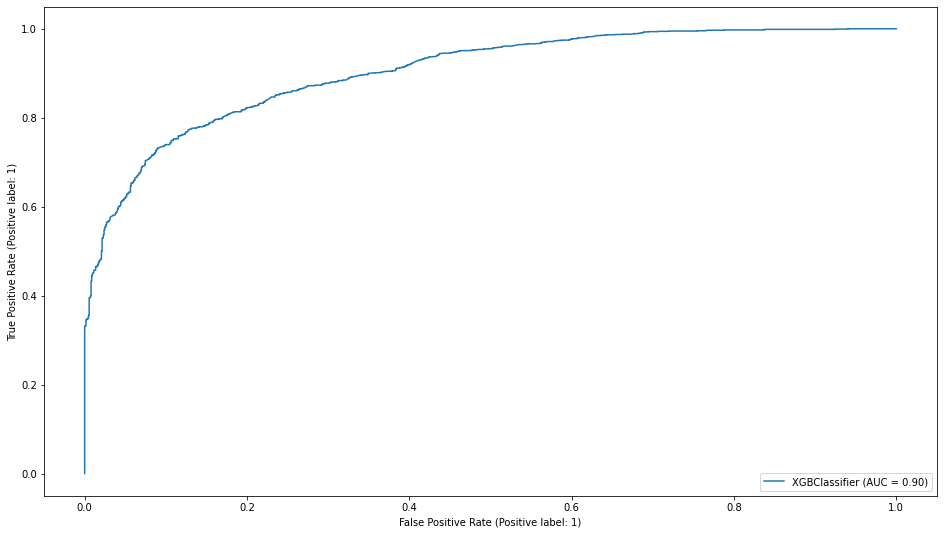

In [74]:
from xgboost import XGBClassifier

XGB_1 = XGBClassifier(objective='binary:logistic',scale_pos_weight=1,n_estimators=85, eta=0.3, subsample=1, colsample_bytree=1)

#learning
XGB_1.fit(X_train,Y_train)
#Prediction
XGB_modelprediction=XGB_1.predict(X_test)

evaluate_model (XGB_1, X_test, y_test, XGB_modelprediction)

**XGB Classifier Ver_2**

Các chỉ số đánh giá mức độ hiệu quả của mô hình: 
1. Accuracy: 0.8434075645104278
2. confusion_matrix:
[[1067  252]
 [ 191 1319]]
3. recall_score:  0.8735099337748344
4. precision_score:  0.8395926161680458
5. f1_score:  0.8562155144433625
6. Biểu đồ ROC của mô hình:


/home/hikaru/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


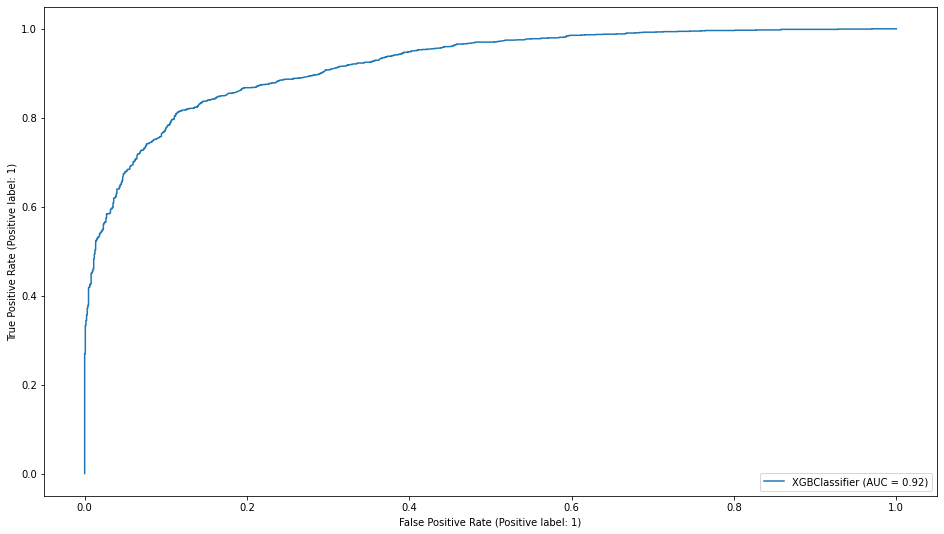

In [50]:
xgb_2 = XGBClassifier(learning_rate=0.4,max_depth=7)
#learning
xgb_2.fit(X_train,Y_train)
#Prediction
xgb_2_modelprediction_v2=xgb_2.predict(X_test)

evaluate_model (xgb_2, X_test, y_test, xgb_2_modelprediction_v2)

Các chỉ số đánh giá mức độ hiệu quả của mô hình: 
1. Accuracy: 0.8434075645104278
2. confusion_matrix:
[[1067  252]
 [ 191 1319]]
3. recall_score:  0.8735099337748344
4. precision_score:  0.8395926161680458
5. f1_score:  0.8562155144433625
6. Biểu đồ ROC của mô hình:


/home/hikaru/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


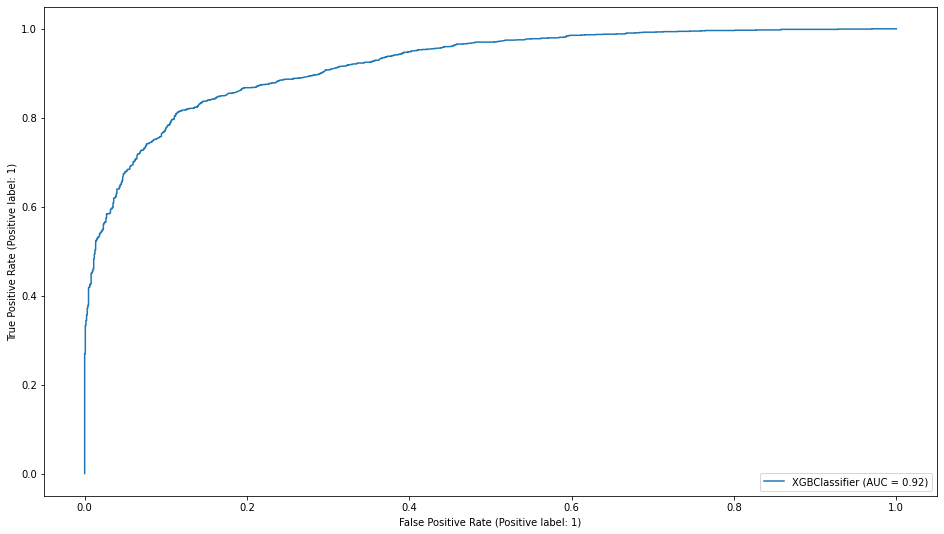

In [51]:
from xgboost import XGBClassifier

# instantiate the model
xgb_3 = XGBClassifier(learning_rate=0.4,max_depth=7)
#fit the model
xgb_3.fit(X_train, Y_train)

#predicting the target value from the model for the samples
y_test_xgb = xgb_3.predict(X_test)

evaluate_model (xgb_3, X_test, y_test, y_test_xgb)

**Light GBM**

Các chỉ số đánh giá mức độ hiệu quả của mô hình: 
1. Accuracy: 0.6171792152704135
2. confusion_matrix:
[[1254 1079]
 [   4  492]]
3. recall_score:  0.9919354838709677
4. precision_score:  0.31317632081476765
5. f1_score:  0.47605224963715526
6. Biểu đồ ROC của mô hình:


/home/hikaru/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


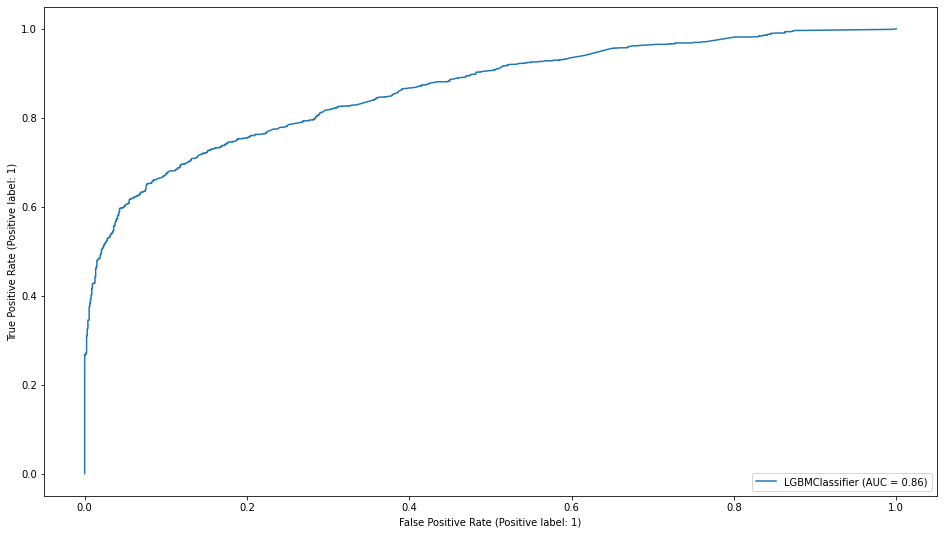

In [52]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, objective='binary',
                          class_weight={0:25, 1:1}, learning_rate=0.01,
                          boosting_type='dart')
lgbm_clf.fit(X_train, Y_train)

#Prediction
LGBM_modelprediction=lgbm_clf.predict(X_test)

evaluate_model (lgbm_clf, X_test, y_test, LGBM_modelprediction)

**Votting Classifier**

Các chỉ số đánh giá mức độ hiệu quả của mô hình: 
1. Accuracy: 0.839519264757865
2. confusion_matrix:
[[1090  286]
 [ 168 1285]]
3. recall_score:  0.8843771507226428
4. precision_score:  0.8179503500954806
5. f1_score:  0.8498677248677249
6. Biểu đồ ROC của mô hình:


/home/hikaru/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


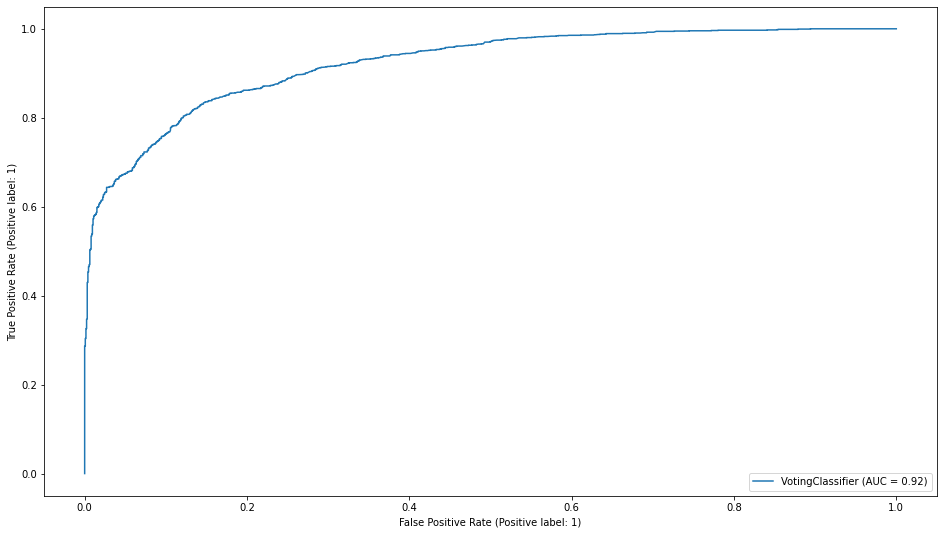

In [53]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, \
    ExtraTreesClassifier, VotingClassifier

clf1 = RandomForestClassifier(n_estimators=200, class_weight={0: 100, 1: 1})
clf2 = GradientBoostingClassifier(n_estimators=1000, max_depth=7)
clf3 = ExtraTreesClassifier(n_estimators=1000, class_weight={0: 100, 1: 1})
clf4 = XGBClassifier(n_estimators=1000, max_depth=5, learning_rate=0.01)
pos_clf = VotingClassifier(estimators=[('pos', clf1), ('gb', clf2),
                                        ('et', clf3), ('xgb', clf4)],
                            voting='soft',
                            weights=[1, 2, 1, 1])

pos_clf.fit(X_train, Y_train)

#Prediction
Vot_modelprediction=pos_clf.predict(X_test)

evaluate_model (pos_clf, X_test, y_test, Vot_modelprediction)

**Gradient Boosting Classifier**

Các chỉ số đánh giá mức độ hiệu quả của mô hình: 
1. Accuracy: 0.8377518557794273
2. confusion_matrix:
[[1057  258]
 [ 201 1313]]
3. recall_score:  0.8672391017173051
4. precision_score:  0.8357733927434755
5. f1_score:  0.8512155591572124
6. Biểu đồ ROC của mô hình:


/home/hikaru/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


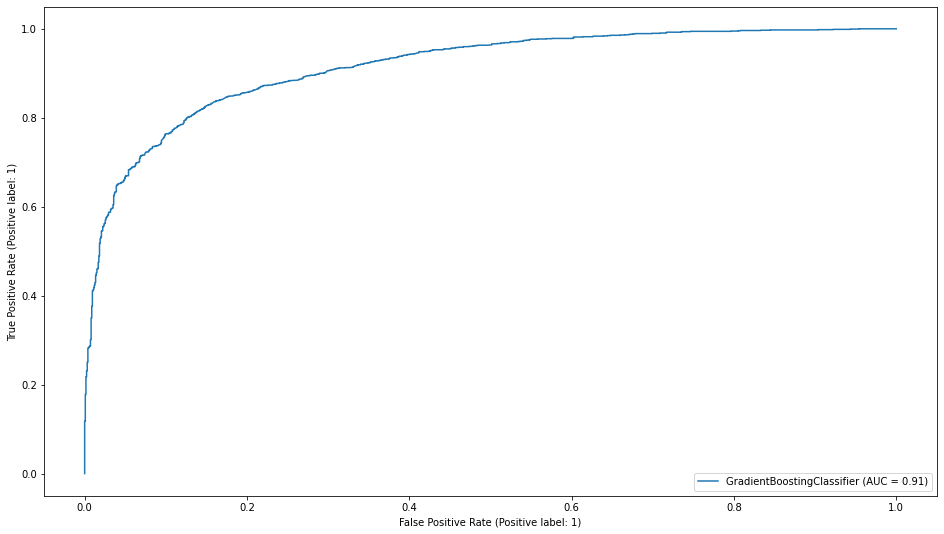

In [54]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, \
    ExtraTreesClassifier, VotingClassifier

GBoost = GradientBoostingClassifier(n_estimators=1000, max_depth=7)


GBoost.fit(X_train, Y_train)

#Prediction
GBoost_modelprediction=GBoost.predict(X_test)

evaluate_model (GBoost, X_test, y_test, GBoost_modelprediction)

**Extra Trees Classifier**

Các chỉ số đánh giá mức độ hiệu quả của mô hình: 
1. Accuracy: 0.807705903145988
2. confusion_matrix:
[[1070  356]
 [ 188 1215]]
3. recall_score:  0.8660014255167499
4. precision_score:  0.7733927434754934
5. f1_score:  0.8170813718897109
6. Biểu đồ ROC của mô hình:


/home/hikaru/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


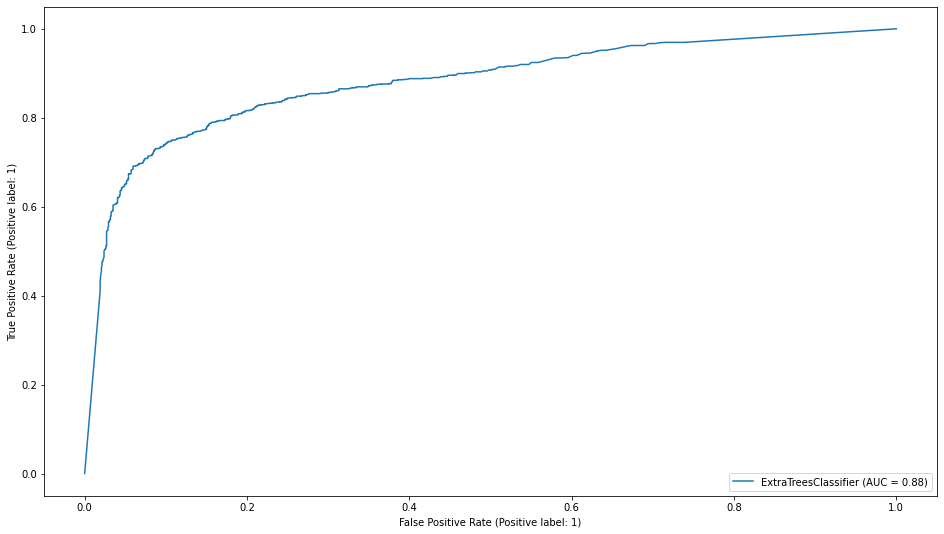

In [55]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, \
    ExtraTreesClassifier, VotingClassifier

Extra = ExtraTreesClassifier(n_estimators=1000, class_weight={0: 100, 1: 1})


Extra.fit(X_train, Y_train)

#Prediction
Extra_modelprediction=Extra.predict(X_test)

evaluate_model (Extra, X_test, y_test, Extra_modelprediction)

**Cat Boosting**

In [56]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


0:	learn: 0.6295664	total: 15.9ms	remaining: 15.9s
1:	learn: 0.5918758	total: 27ms	remaining: 13.5s
2:	learn: 0.5709045	total: 36.7ms	remaining: 12.2s
3:	learn: 0.5505948	total: 47.5ms	remaining: 11.8s
4:	learn: 0.5299323	total: 57.5ms	remaining: 11.4s
5:	learn: 0.5161239	total: 68.5ms	remaining: 11.4s
6:	learn: 0.5059914	total: 79.2ms	remaining: 11.2s
7:	learn: 0.4924444	total: 90.5ms	remaining: 11.2s
8:	learn: 0.4847083	total: 103ms	remaining: 11.4s
9:	learn: 0.4759957	total: 114ms	remaining: 11.2s
10:	learn: 0.4717433	total: 123ms	remaining: 11s
11:	learn: 0.4630518	total: 134ms	remaining: 11.1s
12:	learn: 0.4603867	total: 144ms	remaining: 11s
13:	learn: 0.4545013	total: 156ms	remaining: 11s
14:	learn: 0.4503583	total: 166ms	remaining: 10.9s
15:	learn: 0.4483451	total: 176ms	remaining: 10.8s
16:	learn: 0.4448423	total: 186ms	remaining: 10.7s
17:	learn: 0.4409057	total: 196ms	remaining: 10.7s
18:	learn: 0.4357956	total: 206ms	remaining: 10.6s
19:	learn: 0.4337300	total: 216ms	remaini

164:	learn: 0.2693586	total: 1.85s	remaining: 9.35s
165:	learn: 0.2690593	total: 1.86s	remaining: 9.34s
166:	learn: 0.2689261	total: 1.87s	remaining: 9.32s
167:	learn: 0.2686043	total: 1.88s	remaining: 9.31s
168:	learn: 0.2679717	total: 1.89s	remaining: 9.29s
169:	learn: 0.2672529	total: 1.9s	remaining: 9.28s
170:	learn: 0.2668088	total: 1.91s	remaining: 9.26s
171:	learn: 0.2660313	total: 1.92s	remaining: 9.24s
172:	learn: 0.2654766	total: 1.93s	remaining: 9.23s
173:	learn: 0.2643867	total: 1.95s	remaining: 9.28s
174:	learn: 0.2640468	total: 1.96s	remaining: 9.26s
175:	learn: 0.2629906	total: 1.97s	remaining: 9.24s
176:	learn: 0.2622653	total: 1.98s	remaining: 9.23s
177:	learn: 0.2622286	total: 1.99s	remaining: 9.21s
178:	learn: 0.2615980	total: 2s	remaining: 9.19s
179:	learn: 0.2599092	total: 2.01s	remaining: 9.18s
180:	learn: 0.2597240	total: 2.02s	remaining: 9.16s
181:	learn: 0.2589686	total: 2.03s	remaining: 9.14s
182:	learn: 0.2585039	total: 2.04s	remaining: 9.13s
183:	learn: 0.25

330:	learn: 0.2107463	total: 3.68s	remaining: 7.44s
331:	learn: 0.2105737	total: 3.69s	remaining: 7.43s
332:	learn: 0.2103686	total: 3.71s	remaining: 7.42s
333:	learn: 0.2102150	total: 3.72s	remaining: 7.42s
334:	learn: 0.2099593	total: 3.73s	remaining: 7.4s
335:	learn: 0.2091999	total: 3.74s	remaining: 7.4s
336:	learn: 0.2089714	total: 3.76s	remaining: 7.4s
337:	learn: 0.2087946	total: 3.77s	remaining: 7.39s
338:	learn: 0.2084781	total: 3.78s	remaining: 7.38s
339:	learn: 0.2083345	total: 3.79s	remaining: 7.37s
340:	learn: 0.2076502	total: 3.81s	remaining: 7.35s
341:	learn: 0.2074340	total: 3.81s	remaining: 7.34s
342:	learn: 0.2070782	total: 3.83s	remaining: 7.33s
343:	learn: 0.2068146	total: 3.84s	remaining: 7.32s
344:	learn: 0.2065525	total: 3.85s	remaining: 7.3s
345:	learn: 0.2065493	total: 3.86s	remaining: 7.29s
346:	learn: 0.2065393	total: 3.87s	remaining: 7.28s
347:	learn: 0.2065313	total: 3.88s	remaining: 7.26s
348:	learn: 0.2063705	total: 3.89s	remaining: 7.25s
349:	learn: 0.20

499:	learn: 0.1811249	total: 5.97s	remaining: 5.97s
500:	learn: 0.1806938	total: 5.99s	remaining: 5.96s
501:	learn: 0.1804258	total: 6s	remaining: 5.95s
502:	learn: 0.1801655	total: 6.01s	remaining: 5.93s
503:	learn: 0.1798995	total: 6.02s	remaining: 5.92s
504:	learn: 0.1797196	total: 6.03s	remaining: 5.91s
505:	learn: 0.1793918	total: 6.04s	remaining: 5.89s
506:	learn: 0.1791638	total: 6.05s	remaining: 5.88s
507:	learn: 0.1787544	total: 6.06s	remaining: 5.87s
508:	learn: 0.1785340	total: 6.07s	remaining: 5.86s
509:	learn: 0.1782518	total: 6.08s	remaining: 5.84s
510:	learn: 0.1782217	total: 6.09s	remaining: 5.83s
511:	learn: 0.1779149	total: 6.1s	remaining: 5.81s
512:	learn: 0.1778936	total: 6.11s	remaining: 5.8s
513:	learn: 0.1774715	total: 6.12s	remaining: 5.79s
514:	learn: 0.1774649	total: 6.13s	remaining: 5.77s
515:	learn: 0.1773418	total: 6.14s	remaining: 5.76s
516:	learn: 0.1770370	total: 6.15s	remaining: 5.75s
517:	learn: 0.1769318	total: 6.16s	remaining: 5.73s
518:	learn: 0.176

675:	learn: 0.1586878	total: 8.03s	remaining: 3.85s
676:	learn: 0.1586617	total: 8.04s	remaining: 3.84s
677:	learn: 0.1584888	total: 8.06s	remaining: 3.83s
678:	learn: 0.1582610	total: 8.09s	remaining: 3.83s
679:	learn: 0.1581511	total: 8.11s	remaining: 3.82s
680:	learn: 0.1581422	total: 8.13s	remaining: 3.81s
681:	learn: 0.1581266	total: 8.14s	remaining: 3.8s
682:	learn: 0.1581264	total: 8.15s	remaining: 3.78s
683:	learn: 0.1580239	total: 8.17s	remaining: 3.78s
684:	learn: 0.1578734	total: 8.18s	remaining: 3.76s
685:	learn: 0.1577370	total: 8.2s	remaining: 3.75s
686:	learn: 0.1577273	total: 8.2s	remaining: 3.74s
687:	learn: 0.1577200	total: 8.21s	remaining: 3.73s
688:	learn: 0.1576818	total: 8.22s	remaining: 3.71s
689:	learn: 0.1576016	total: 8.23s	remaining: 3.7s
690:	learn: 0.1574068	total: 8.25s	remaining: 3.69s
691:	learn: 0.1573137	total: 8.26s	remaining: 3.68s
692:	learn: 0.1572699	total: 8.27s	remaining: 3.66s
693:	learn: 0.1571623	total: 8.28s	remaining: 3.65s
694:	learn: 0.15

846:	learn: 0.1439636	total: 10.1s	remaining: 1.82s
847:	learn: 0.1439533	total: 10.1s	remaining: 1.81s
848:	learn: 0.1439492	total: 10.1s	remaining: 1.8s
849:	learn: 0.1438271	total: 10.1s	remaining: 1.79s
850:	learn: 0.1438177	total: 10.1s	remaining: 1.78s
851:	learn: 0.1437675	total: 10.2s	remaining: 1.76s
852:	learn: 0.1436956	total: 10.2s	remaining: 1.75s
853:	learn: 0.1436613	total: 10.2s	remaining: 1.74s
854:	learn: 0.1435439	total: 10.2s	remaining: 1.73s
855:	learn: 0.1434226	total: 10.2s	remaining: 1.72s
856:	learn: 0.1432183	total: 10.2s	remaining: 1.7s
857:	learn: 0.1431614	total: 10.2s	remaining: 1.69s
858:	learn: 0.1431037	total: 10.2s	remaining: 1.68s
859:	learn: 0.1430271	total: 10.2s	remaining: 1.67s
860:	learn: 0.1428991	total: 10.2s	remaining: 1.65s
861:	learn: 0.1427857	total: 10.3s	remaining: 1.64s
862:	learn: 0.1426444	total: 10.3s	remaining: 1.63s
863:	learn: 0.1425752	total: 10.3s	remaining: 1.62s
864:	learn: 0.1424661	total: 10.3s	remaining: 1.61s
865:	learn: 0.

/home/hikaru/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


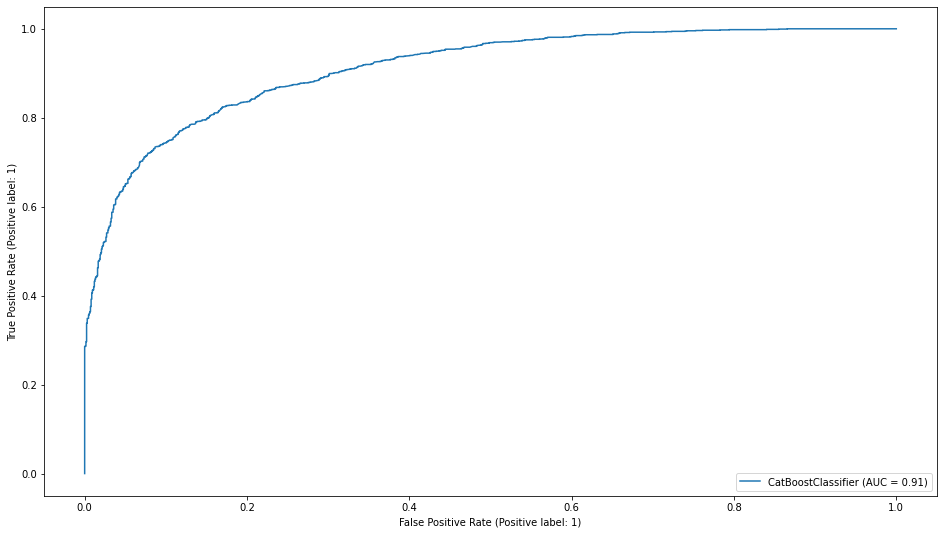

In [81]:
from catboost import CatBoostClassifier

model_catboss = CatBoostClassifier(learning_rate = 0.2, depth = 8, rsm = 1)

model_catboss.fit(X_train, Y_train)

#Prediction
cast_modelprediction=model_catboss.predict(X_test)

evaluate_model (model_catboss, X_test, y_test, cast_modelprediction)

# **Deep Learning**

# **ANN**

In [58]:
# Import the necessary libraries for ANN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

2022-06-03 13:00:40.875553: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-03 13:00:40.875587: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [59]:
# Create a Sequential Neural Network model 
model = Sequential()
# Create an Input and a Hidden Layer
model.add(Dense(units=50,activation="relu",kernel_initializer="he_uniform"))
# Create an Output Layer
model.add(Dense(units=1,activation="sigmoid"))
# Now, my model is ready to compile
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

2022-06-03 13:00:45.001829: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-03 13:00:45.001867: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-03 13:00:45.001901: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ThinkPad-L540): /proc/driver/nvidia/version does not exist
2022-06-03 13:00:45.002833: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [60]:
model.fit(X_train,y_train,batch_size=64,epochs=100)

ValueError: Data cardinality is ambiguous:
  x sizes: 11313
  y sizes: 9899
Make sure all arrays contain the same number of samples.

In [ ]:
model.summary()

In [ ]:
# Predict the X_test results
y_pred = model.predict(X_test)

In [ ]:
y_pred_label = []
for i in range(0, len(y_pred)):
  if y_pred[i] >= 0.5:
    y_pred_label.append(1)
  else:
    y_pred_label.append(0)

In [ ]:
print("Các chỉ số đánh giá mức độ hiệu quả của mô hình: ")
#Accuracy
print("1. Accuracy:",metrics.accuracy_score(y_pred_label,y_test))
# confusion_matrix
print('2. confusion_matrix:')
print(confusion_matrix(y_pred_label,y_test))
# recall_score
print('3. recall_score: ', recall_score(y_pred_label,y_test))
# precision_score
print('4. precision_score: ', precision_score(y_pred_label,y_test))
# f1_score
print('5. f1_score: ', f1_score(y_pred_label,y_test))

# **LSTM**

In [ ]:
# Import the necessary libraries for ANN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from keras.layers import Dropout

In [ ]:
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

In [ ]:
regressor.summary()

In [ ]:
# Predict the X_test results
y_pred = regressor.predict(X_test)

In [ ]:
y_pred_label = []
for i in range(0, len(y_pred)):
  if y_pred[i] >= 0.5:
    y_pred_label.append(1)
  else:
    y_pred_label.append(0)

In [ ]:
print("Các chỉ số đánh giá mức độ hiệu quả của mô hình: ")
#Accuracy
print("1. Accuracy:",metrics.accuracy_score(y_pred_label,y_test))
# confusion_matrix
print('2. confusion_matrix:')
print(confusion_matrix(y_pred_label,y_test))
# recall_score
print('3. recall_score: ', recall_score(y_pred_label,y_test))
# precision_score
print('4. precision_score: ', precision_score(y_pred_label,y_test))
# f1_score
print('5. f1_score: ', f1_score(y_pred_label,y_test))

# ***Kết thúc!***